In [1]:
#|default_exp conv

# Convoltions

In [2]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd().parent))

In [3]:
#|export
import torch
from torch import nn

from torch.utils.data import default_collate
from typing import Mapping

from miniai.training import *
from miniai.datasets import *

In [4]:
import pickle, gzip, math, os, time, shutil, torch, matplotlib as mpl, numpy as np
import pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor

from torch.utils.data import DataLoader
from typing import Mapping

In [5]:
mpl.rcParams['image.cmap'] = 'gray'

In [6]:
path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

In the context of an image, a feature is a visually distinctive attribute. For example, the number 7 is characterized by a horizontal edge near the top of the digit, and a top-right to bottom-left diagonal edge underneath that.

It turns out that finding the edges in an image is a very common task in computer vision, and is surprisingly straightforward. To do it, we use a convolution. A convolution requires nothing more than multiplication, and addition.

### Understanding Convolutions
To explain the math behind the convolutions, Read: https://medium.com/impactai/cnns-from-different-viewpoints-fab7f52d159c

In [7]:
x_imgs = x_train.view(-1,28,28)
xv_imgs = x_valid.view(-1,28,28)

In [8]:
mpl.rcParams['figure.dpi'] = 30

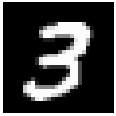

In [9]:
im3 = x_imgs[7]
show_image(im3);

In [10]:
top_edge = tensor([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]])

The top_edge is known as kernel

<Axes: >

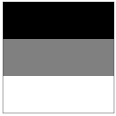

In [11]:
show_image(top_edge, noframe=False)

The filter will take any window of size 3×3 in our images, and if we name the pixel values like this: a1, a2.., a9
it will return −a1−a2−a3+a7+a8+a9

In [12]:
df = pd.DataFrame(im3[:13, :23])
df.style.format(precision=2).set_properties(**{'font-size':'7pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.17,0.41,1.00,0.99,0.99,0.99,0.99,0.99,0.68,0.02,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.54,0.88,0.88,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.62,0.05
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.70,0.98,0.98,0.98,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.23
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.43,0.98,0.98,0.90,0.52,0.52,0.52,0.52,0.74,0.98,0.98,0.98,0.98,0.23
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.11,0.11,0.09,0.00,0.00,0.00,0.00,0.05,0.88,0.98,0.98,0.67,0.03


In [13]:
(im3[3:6, 14:17] * top_edge).sum()

tensor(2.9727)

In [14]:
(im3[7:10, 14:17] * top_edge).sum()

tensor(-2.9570)

In [15]:
def apply_kernel(row, col, kernel): return (im3[row-1: row+2, col-1: col+2] * kernel).sum()

In [16]:
apply_kernel(4, 15, top_edge)

tensor(2.9727)

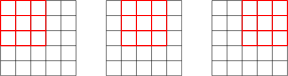

In [17]:
[[(i,j) for j in range(6, 11)] for i in range(5)]

[[(0, 6), (0, 7), (0, 8), (0, 9), (0, 10)],
 [(1, 6), (1, 7), (1, 8), (1, 9), (1, 10)],
 [(2, 6), (2, 7), (2, 8), (2, 9), (2, 10)],
 [(3, 6), (3, 7), (3, 8), (3, 9), (3, 10)],
 [(4, 6), (4, 7), (4, 8), (4, 9), (4, 10)]]

<Axes: >

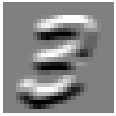

In [18]:
rng = range(1, 27)
top_edge3 = tensor([[apply_kernel(i, j, top_edge) for j in rng] for i in rng])
show_image(top_edge3)

In [19]:
left_edge = tensor([[-1., 0., 1.],
                    [-1., 0., 1.],
                    [-1., 0., 1.]])

<Axes: >

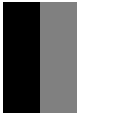

In [20]:
show_image(left_edge)

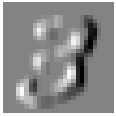

In [21]:
left_edge3 = tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng])
show_image(left_edge3);

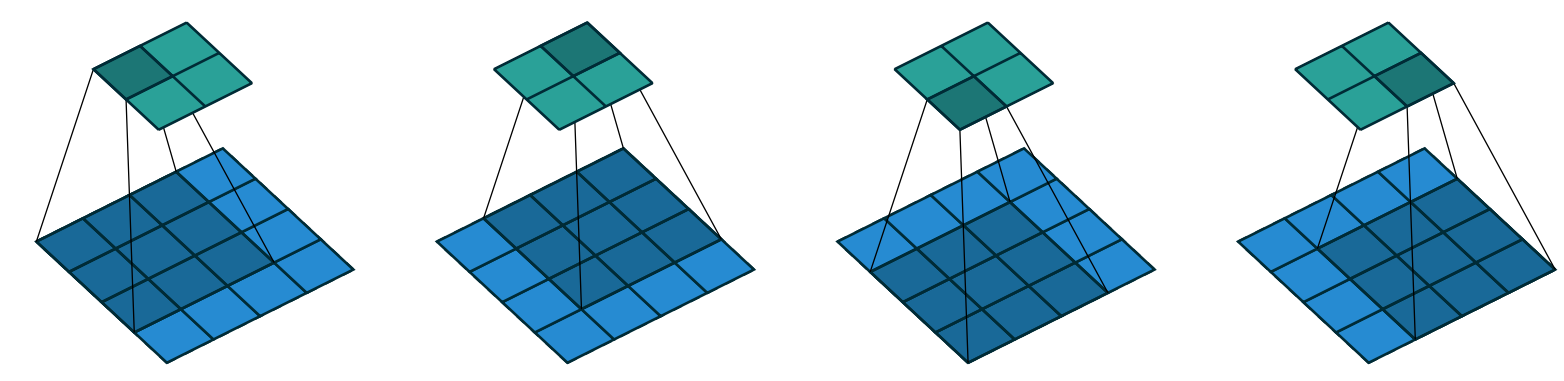

## Convolution in Pytorch

In [22]:
import torch.nn.functional as F
import torch

https://inria.hal.science/inria-00112631/ \
Quick Implementation of Conv using Caffe: https://github.com/Yangqing/caffe/wiki/Convolution-in-Caffe:-a-memo
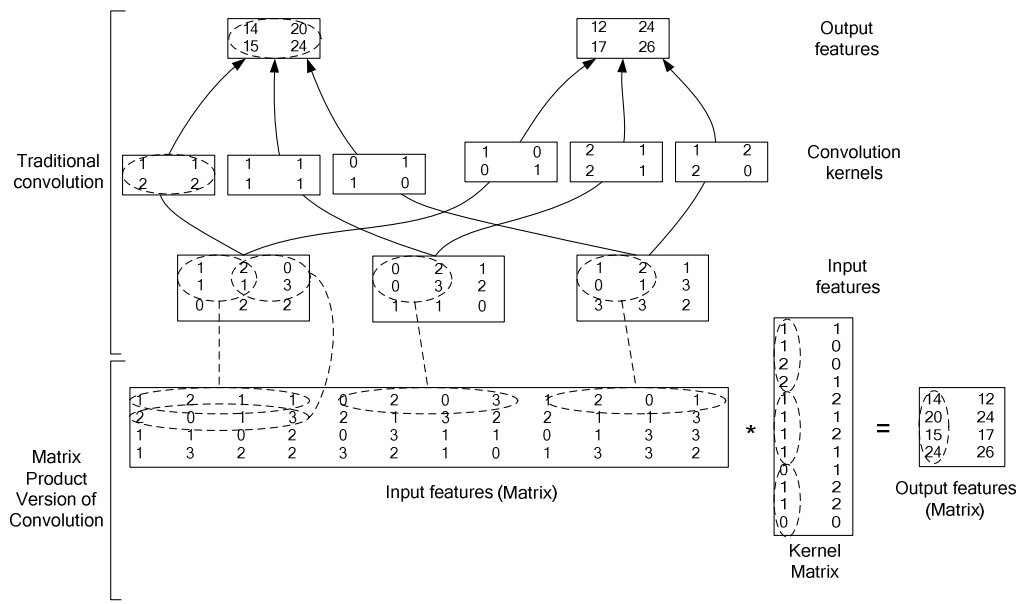

In [23]:
inp = im3[None,None,:,:].float()
# inp = (N, C, *) where N is bs, C is no of input channels, * is spatial dimmension
inp_unf = F.unfold(inp, (3,3))[0]
inp_unf.shape

torch.Size([9, 676])

Inp_unf.shape => (n+2p-ks//strid) + 1 = 26*26 = 676

https://pytorch.org/docs/stable/generated/torch.nn.functional.unfold.html#torch.nn.functional.unfold

In [24]:
w = left_edge.view(-1)
w.shape, w

(torch.Size([9]), tensor([-1.,  0.,  1., -1.,  0.,  1., -1.,  0.,  1.]))

In [25]:
out_unf = w@inp_unf
out_unf.shape

torch.Size([676])

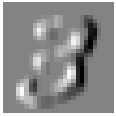

In [26]:
out = out_unf.view(26,26)
show_image(out);

In [27]:
%timeit -n 1 tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng]);

9.4 ms ± 1.54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
%timeit -n 100 (w@F.unfold(inp, (3,3))[0]).view(26,26);

36.9 µs ± 9.82 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [29]:
%timeit -n 100 F.conv2d(inp, left_edge[None, None])

26.3 µs ± 11.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [30]:
diag1_edge = tensor([[0, -1, 1],
                    [-1, 1, 0],
                    [ 1, 0, 0]]).float()

<Axes: >

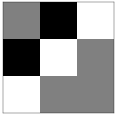

In [31]:
show_image(diag1_edge, noframe=False)

<Axes: >

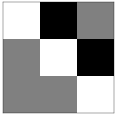

In [32]:
diag2_edge = tensor([[ 1,-1, 0],
                     [ 0, 1,-1],
                     [ 0, 0, 1]]).float()
show_image(diag2_edge, noframe=False)

In [33]:
xb = x_imgs[:16][:, None]
xb.shape

torch.Size([16, 1, 28, 28])

In [34]:
edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])[:, None]
edge_kernels.shape

torch.Size([4, 1, 3, 3])

In [35]:
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([16, 4, 26, 26])

The output shape shows we gave 64 images in the mini-batch, 4 kernels, and 26×26 edge maps (we started with 28×28 images, but lost one pixel from each side as discussed earlier). We can see we get the same results as when we did this manually:

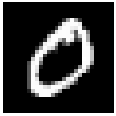

In [36]:
img0 = xb[1, 0]
show_image(img0);

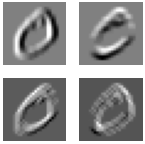

In [37]:
show_images([batch_features[1,i] for i in range(4)])

### Strides and Padding
With appropriate padding, we can ensure that the output activation map is the same size as orignal image.
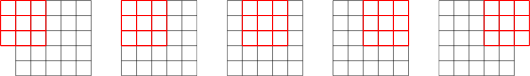
With a 5×5 input, 4×4 kernel, and 2 pixels of padding, we end up with a 6×6 activation map.
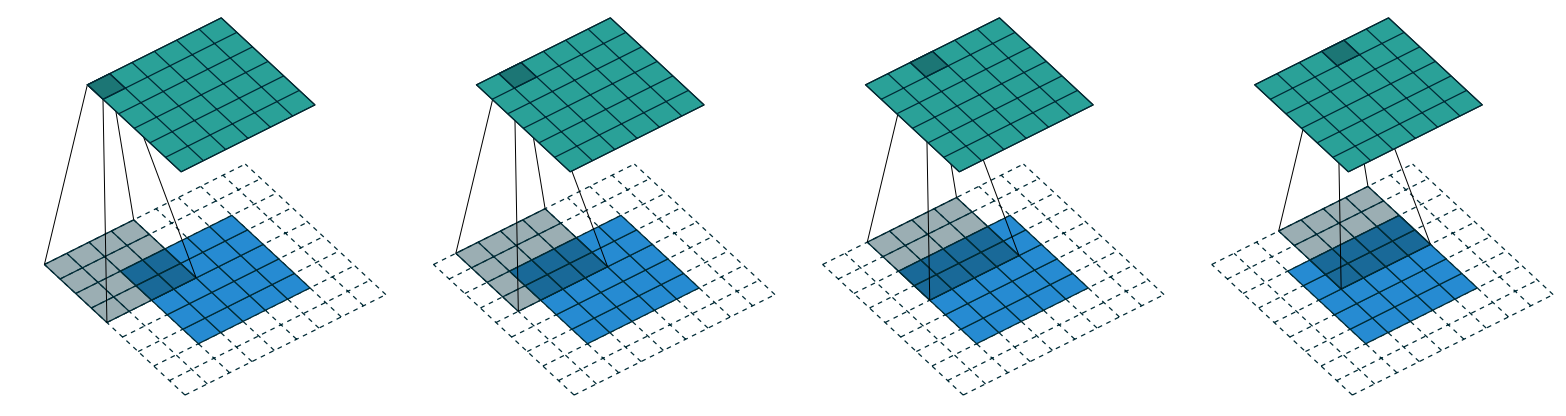
If we add a kernel of size ks by ks (with ks an odd number), the necessary padding on each side to keep the same shape is ks//2.
We could move over two pixels after each kernel application. This is known as a stride-2 convolution.

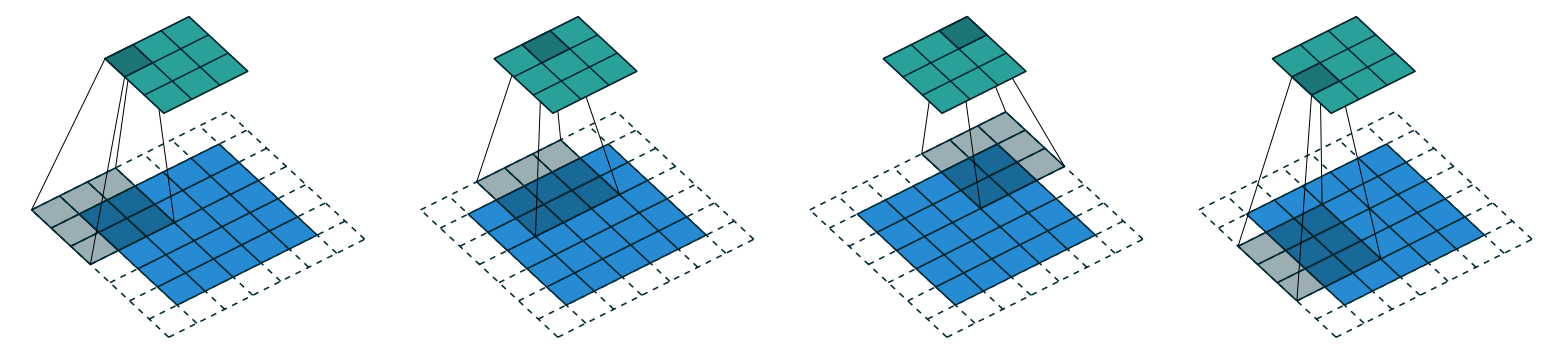

# Creating CNN

In [38]:
n, m = x_train.shape
c = y_train.max() + 1
nh = 50

In [39]:
model = nn.Sequential(nn.Linear(m, nh),
                      nn.ReLU(),
                      nn.Linear(nh, 10))

In [40]:
# torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, 
# dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
broken_cnn = nn.Sequential(nn.Conv2d(1, 30, kernel_size=3, padding=1),
                           nn.ReLU(),
                           nn.Conv2d(30, 10, kernel_size=3, padding=1))
# Output shape when xb is passed
broken_cnn(xb).shape

torch.Size([16, 10, 28, 28])

In [41]:
#|export
def conv(ni, nf, ks=3, stride=2, act=True):
    res=nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

Refactoring parts of your neural networks like this makes it much less likely you'll get errors due to inconsistencies in your architectures, and makes it more obvious to the reader which parts of your layers are actually changing.

In [42]:
simple_cnn = nn.Sequential(
    conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,16),           #2x2
    conv(16,10, act=False), #1x1
    nn.Flatten(),
)

In [43]:
simple_cnn(xb).shape

torch.Size([16, 10])

In [44]:
x_imgs = x_train.view(-1, 1, 28, 28)
xv_imgs = x_valid.view(-1, 1, 28, 28)
train_ds, valid_ds = Dataset(x_imgs, y_train), Dataset(xv_imgs, y_valid)

In [45]:
#|export
def_device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

def to_device(x, device=def_device):
    if isinstance(x, torch.Tensor): return x.to(device)
    if isinstance(x, Mapping): return {k:v.to(device) for k, v in x.items()}
    return type(x)(to_device(o, device) for o in x)

def collate_device(b): return to_device(default_collate(b))

https://mypy.readthedocs.io/en/stable/cheat_sheet_py3.html#standard-duck-types

In [46]:
from torch import optim

bs = 256
lr = 0.4
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs, collate_fn=collate_device)
opt = optim.SGD(simple_cnn.parameters(), lr)

In [47]:
loss, acc = fit(5, simple_cnn.to(def_device), F.cross_entropy, opt, train_dl, valid_dl)

0 0.5302507350921631 0.8234
1 0.24036049114465713 0.9282
2 0.16547112848311663 0.9487
3 0.330139252948761 0.8983
4 0.11829749217629433 0.9649


In [48]:
opt = optim.SGD(simple_cnn.parameters(), lr=lr/4)
loss,acc = fit(5, simple_cnn.to(def_device), F.cross_entropy, opt, train_dl, valid_dl)

0 0.08763015037849546 0.9746
1 0.0855524770885706 0.975
2 0.0861599047780037 0.9755
3 0.08531039848774671 0.9759
4 0.09014136990010739 0.9717


### Understanding Convolution Arithmetic
In an input of size `4x1x28x28` the axes are `batch,channel,height,width` This is often represented as `NCHW` (where N refers to batch size). Tensorflow, on the other hand, uses NHWC axis order (aka "channels-last"). Channels-last is faster for many models, so recently it's become more common to see this as an option in PyTorch too.


We have 1 input channel, 4 output channels, and a 3×3 kernel.

In [49]:
simple_cnn[0][0]

Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))

In [50]:
conv1 = simple_cnn[0][0]
conv1.weight.shape

torch.Size([4, 1, 3, 3])

In [51]:
conv1.bias.shape

torch.Size([4])

The receptive field is the area of an image that is involved in the calculation of a layer. conv-example.xlsx shows the calculation of two stride-2 convolutional layers using an MNIST digit. Here's what we see if we click on one of the cells in the conv2 section, which shows the output of the second convolutional layer, and click trace precedents.


The blue highlighted cells are its precedents—that is, the cells used to calculate its value. These cells are the corresponding 3×3 area of cells from the input layer (on the left), and the cells from the filter (on the right). Click trace precedents again:

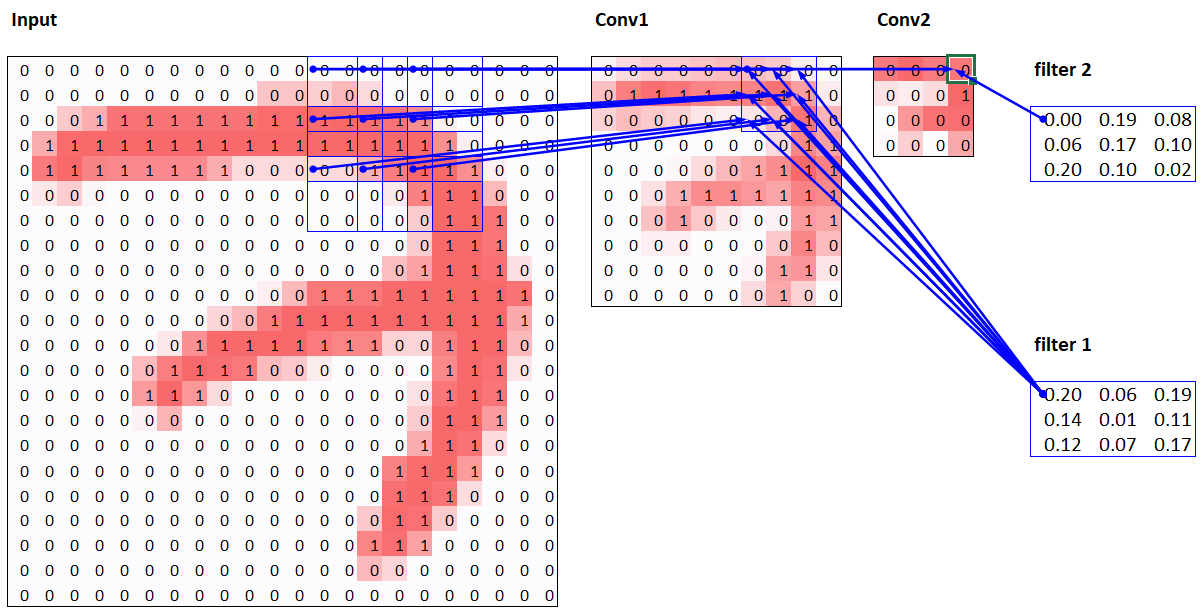

In this example, we have just two convolutional layers. We can see that a 7×7 area of cells in the input layer is used to calculate the single green cell in the Conv2 layer. This is the receptive field

The deeper we are in the network (specifically, the more stride-2 convs we have before a layer), the larger the receptive field for an activation in that layer.

### Color Images
A colour picture is a rank-3 tensor:

In [52]:
from torchvision.io import read_image
im = read_image('textual_inversion_photos/IMG_20240422_183842920.jpg')
im.shape

torch.Size([3, 4080, 3072])

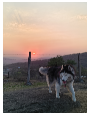

In [53]:
show_image(im.permute(1,2,0));

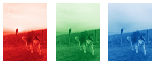

In [54]:
_,axs = plt.subplots(1,3)
for bear,ax,color in zip(im,axs,('Reds','Greens','Blues')): show_image(255-bear, ax=ax, cmap=color)

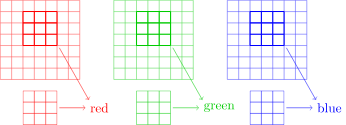
These are then all added together, to produce a single number, for each grid location, for each output feature.
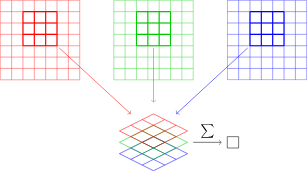
We have ch_out filters like this, so in the end, the result of our convolutional layer will be a batch of images with ch_out channels.

In [55]:
import nbdev; nbdev.nbdev_export()